In [1]:
from simulating_traces.Simulate_measurement import *
import matplotlib.pyplot as plt

## Import data

In [2]:
import json
id_1=2
with open('JPA_off_vs_power_'+str(id_1)+'.json', 'r') as file:
    signal_parameters_fit_read=json.load(file)

## Generate new traces

In [3]:
# Generates distance

# SIMULATION- CREATE DATA

A=signal_parameters_fit_read["A"]
t_in=signal_parameters_fit_read["t_in"]
t_out=signal_parameters_fit_read["t_out"]


E_low=signal_parameters_fit_read["mean_bg"]
E_high=signal_parameters_fit_read["mean_up"]
sigma_low=signal_parameters_fit_read["std_bg"]
sigma_high=signal_parameters_fit_read["std_up"]

E_low=0
E_high=1
sigma_low=0.3
sigma_high=0.3



n_traces=10000
t_max=2000
acq_rate=2

time,spin_traces,spin_number=simulate_measurement(A, t_out, t_in, E_low, sigma_low , E_high, sigma_high, n_traces, t_max, acq_rate)

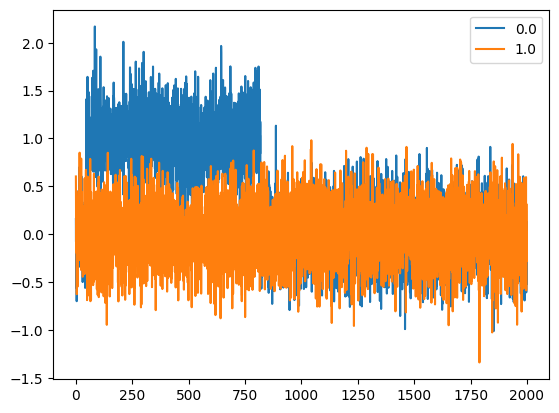

In [4]:

plt.plot(time, spin_traces[0], label=spin_number[0])
plt.plot(time, spin_traces[1], label=spin_number[1])
plt.legend()

# apply filter

In [5]:
factor=10
time_filtered, spin_traces_filtered=moving_avg_filter(spin_traces, time, factor, acq_rate)

In [6]:
time_filtered

array([   4.75,    5.25,    5.75, ..., 1998.75, 1999.25, 1999.75])

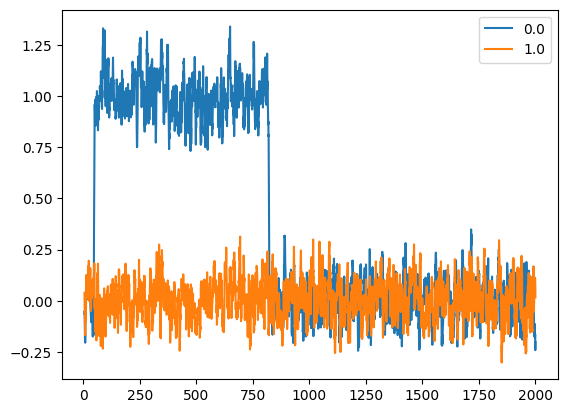

In [7]:
plt.plot(time_filtered,spin_traces_filtered[0], label=spin_number[0])
plt.plot(time_filtered,spin_traces_filtered[1], label=spin_number[1])
plt.legend()

# Create histogram

In [51]:
def max_simulated_histogram(time, spin_traces, spin_number, t_min=0, t_max=None, num_bins=100, plot_histo=True):
	from scipy.interpolate import interp1d
	import matplotlib.pyplot as plt
	''' Creates a histogram with the maximum of the spin traces
	  Parameters
	  ----------
		  time: 1D array
			Time sweep during a measurement
		  spin_traces: 2D array
			All data traces		  
		  spin_number: 1D array
			State of each data trace. 0 is spin up and 1 is spin down 
		  t_min: float
			start of the measurement trace
		  t_max: float
			end of the measurement trace
		  bins: integer
			 number of bins in the histogram
		  Plot: bool
			 True if the histogram needs to be visualised
  '''
	if t_max==None:
		t_max=time.max()
		
	n_traces=len(spin_traces) 
	max_spin_traces=max_all_traces(time, spin_traces, t_min, t_max) # maximum of each trace
	range_min=max_spin_traces.min() 
	range_max=max_spin_traces.max()
	print(range_min)  

	# total histogram
	hist_max_ss, bin_edges_max_ss = np.histogram(max_spin_traces,bins=num_bins,range = (range_min,range_max)) 
	bin_axis_ss= get_inter_bins(bin_edges_max_ss)
	normalisation=( bin_edges_max_ss[1]- bin_edges_max_ss[0])*n_traces # for histogram area =1	

      
	if plot_histo:
        
		bin_width=bin_edges_max_ss[1]-bin_edges_max_ss[0]
       
        # Spin up histogram
		spin_up_maximums=max_spin_traces[np.where(spin_number==0)[0]] # repeated
		hist_max_up, bin_edges_max_up = np.histogram(spin_up_maximums,bins=num_bins,range = (range_min,range_max)) 


        # Spin down histogram
		spin_down_maximums=max_spin_traces[np.where(spin_number==1)[0]] # repeated
		hist_max_down, bin_edges_max_down = np.histogram(spin_down_maximums,bins=num_bins,range = (range_min,range_max)) 

		# Plot the histogram 
		plt.figure()
		plt.bar(bin_axis_ss, hist_max_up/normalisation, width=bin_width,label="spin_up",alpha=0.5)
		plt.bar(bin_axis_ss, hist_max_down/normalisation, width=bin_width,label="spin_down",alpha=0.5)
		plt.xlabel("Signal maxima")
		plt.ylabel("Probability")
		plt.title('Histogram of the readout maxima')
		#print('Parameters for the simulation :')
		#print('T_int = %f us, T_in = %f us, T_out = %f us' %(t_int,t_in,t_out))
		#print('A = %f, std = %f'%(A,std_down))
		#plt.title('Simulated histogram as lines')
		f_hist_inter = interp1d(bin_axis_ss, hist_max_ss/normalisation, kind='cubic') # smoothing the histogram
		plt.plot(bin_axis_ss,f_hist_inter(get_inter_bins(bin_edges_max_ss))) 
		plt.legend()
		plt.show()
 
		
	return(bin_axis_ss,hist_max_ss/normalisation)
	

0.23761590986602393


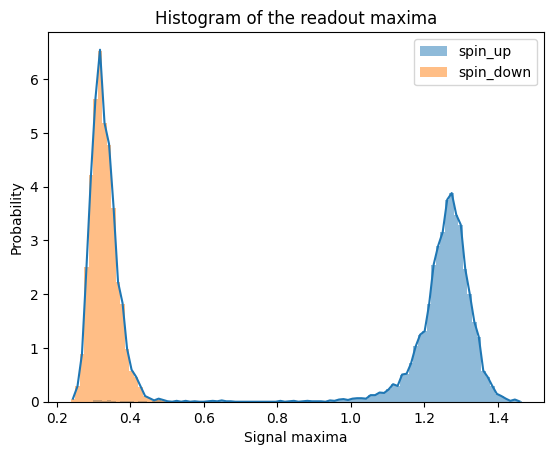

In [52]:
bin_axis_ss,hist_max=max_simulated_histogram(time_filtered,spin_traces_filtered, spin_number)

# Calculate fidelity

In [53]:
def fidelity(time, spin_traces, spin_number, t_min=0, t_max=None, epsilon=0.005, plot_visibility=True):
	''' Creates a histogram with the maximum of the spin traces
	  Parameters
	  ----------
		  time: 1D array
			Time sweep during a measurement
		  spin_traces: 2D array
			All data traces		  
		  spin_number: 1D array
			State of each data trace. 0 is spin up and 1 is spin down 
		  t_min: float
			start of the measurement trace
		  t_max: float
			end of the measurement trace
		  epsilon: float
			delimitant of the threshol. Possible thesholds go from range_min+epsilon to range_max-epsilon 
		  plot_visibility

  '''
	import matplotlib.pyplot as plt
  # repeated from here

	if t_max==None:
		t_max=time.max()
		
	n_traces=len(spin_traces) 
	max_spin_traces=max_all_traces(time, spin_traces, t_min, t_max) # maximum of each trace
	range_min=max_spin_traces.min() 
	range_max=max_spin_traces.max()
	print(range_min)  
 
 # to hear
	signal_threshold = np.linspace(range_min + epsilon, range_max - epsilon,50) # array with all possible thresholds

	fidelity_up = []
	fidelity_down = []

	spin_up_maximums=max_spin_traces[np.where(spin_number==0)[0]]
	spin_down_maximums=max_spin_traces[np.where(spin_number==1)[0]]
	
	for signal in signal_threshold: # calculate the fidelity for each threshold
				integ_up=len(np.where(spin_up_maximums<=signal)[0]) # spin up traces that don't surpass thershold
				integ_down=len(np.where(spin_down_maximums>=signal)[0]) # spin down traces that surpass the thershold

				fidelity_up.append(1-integ_up/n_traces)
				fidelity_down.append(1-integ_down/n_traces)
                
	# Obtain optimal fidelity and visibility
	visibility=np.array(fidelity_up)+np.array(fidelity_down)-1
	integer=np.where(visibility==visibility.max())[0][0]
	fidelity_up_def=np.array(fidelity_up)[integer]
	fidelity_down_def=np.array(fidelity_down)[integer]
	fidelity_tot_def=(fidelity_up_def+fidelity_down_def)/2                
                
	if plot_visibility:
		plt.plot(signal_threshold,fidelity_down, color=(120/255,120/255,120/255), label=r' Spin down fidelity')#Fidelity$_{\downarrow}$')
		plt.plot(signal_threshold,fidelity_up, color= (255/255,66/255,66/255), label=r'Spin up fidelity')#Fidelity$_{\uparrow}$' )
		plt.plot(signal_threshold,np.array(fidelity_up)+np.array(fidelity_down)-1,'--',label='Visbility',c='k')

		plt.legend(loc=1, fontsize=8)
		plt.xlabel("Threshold voltage (V) ", {'color': 'k', 'fontsize': 14})
		plt.ylabel("Fidelity", {'color': 'k', 'fontsize': 14})
		plt.xticks( color='k', size=12)
		plt.yticks( color='k', size=12)
		#plt.savefig("fidelity.png",dpi=600, bbox_inches = "tight", rasterized='True')
		print("max visibility =", visibility.max(),'at', signal_threshold[np.argmax(np.array(fidelity_up)+np.array(fidelity_down)-1)])
		print("max fidelity =", (fidelity_up_def+fidelity_down_def)/2)
	
	
	return fidelity_up_def, fidelity_down_def, fidelity_tot_def


0.23761590986602393
max visibility = 0.9973000000000001 at 0.4660894690464875
max fidelity = 0.99865


(0.998, 0.9993, 0.99865)

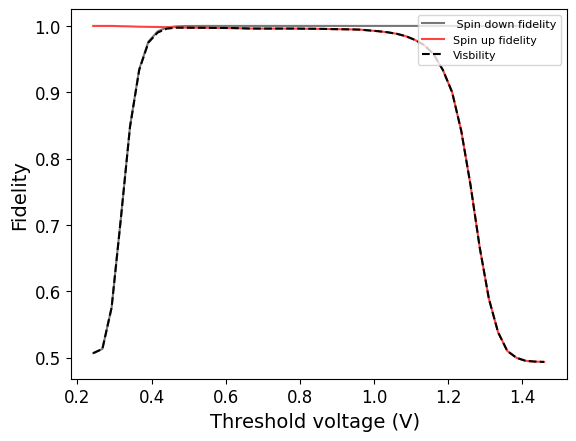

In [55]:
fidelity(time_filtered,spin_traces_filtered, spin_number)